In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel
import pickle
import scipy.sparse
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('modified_amazon.csv')

In [3]:
new_product_df = pd.DataFrame({
    'product_name': ['Samsung 138 cm (55 inches) 4K Ultra HD Smart QLED TV QA55QE1CAKLXL (Titan Gray)'],
    'about_product': ['Resolution : 4K Ultra HD (3840 x 2160) | QLED | Refresh Rate : 50 Hertz Connectivity : 3 HDMI ports to connect set top box or gaming console | 2 USB ports to connect hard drives or other USB devices | Ethernet | Wi-fi | Bluetooth Sound: 20 Watts Output- 2CH | Q-Symphony | OTS+ | Dual Audio Support (Bluetooth) | Buds Auto Switch Smart TV Features : Universal Guide |Media Home | Tap View | Mobile Camera Support | Music Wall |Easy Setup | App Casting | Wireless DeX | SmartThings | Smart Hub |Web Browser | Works with AI Speaker Display : 4K Ultra HD QLED Panel | Quantum Processor Lite 4K | 100% Colour Volume | UHD Dimming Pro | Filmmaker Mode | One Billion Color | Dual LED | Motion Xcelerator'],
    'discounted_price': [64990.0],
    'rating': [4.1],
    'rating_count': [1622.0]
})

In [4]:
with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfv = pickle.load(file)
    
tfv_matrix = scipy.sparse.load_npz('tfidf_matrix.npz')

In [5]:
df

,product_name,discounted_price,rating,rating_count,about_product,review_content
0,Wayona Nylon Braided USB to Lightning Fast Cha...,399.0,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,Looks durable Charging is fine tooNo complains...
1,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,199.0,4.0,43994.0,"Compatible with all Type C enabled devices, be...",I ordered this cable to connect my phone to An...
2,Sounce Fast Phone Charging Cable & Data Sync U...,199.0,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,"Not quite durable and sturdy,https://m.media-a..."
3,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,329.0,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,"Good product,long wire,Charges good,Nice,I bou..."
4,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,154.0,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"Bought this instead of original apple, does th..."
...,...,...,...,...,...,...
1457,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,379.0,4.0,1090.0,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,"I received product without spanner,Excellent p..."
1458,Prestige Delight PRWO Electric Rice Cooker (1 ...,2280.0,4.1,4118.0,"230 Volts, 400 watts, 1 Year","ok,got everything as mentioned but the measuri..."
1459,Bajaj Majesty RX10 2000 Watts Heat Convector R...,2219.0,3.6,468.0,International design and styling|Two heat sett...,"plastic but cool body ,u have to find sturdy s..."
1460,Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,1399.0,4.0,8031.0,Fan sweep area: 230 MM ; Noise level: (40 - 45...,I have installed this in my kitchen working fi...


In [8]:
def give_rec(new_product_df):
    
    tfv_matrix_new = tfv.transform(new_product_df['about_product'])
    
    sig = sigmoid_kernel(tfv_matrix, tfv_matrix_new)
            
    sig_scores = list(enumerate(sig))
    
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
    
    sig_scores = sig_scores[1:71]
    
    product_indices = [i[0] for i in sig_scores]
    
    dfw = df[['product_name','discounted_price','rating', 'rating_count', 'review_content']].iloc[product_indices]
    
    v=dfw['rating_count']
    R=dfw['rating']
    C=dfw['rating'].mean()
    m=dfw['rating_count'].quantile(0.70)
        
    dfw['weighted_average']=((R*v)+ (C*m))/(v+m)
        
    dfw['pd'] = abs(dfw['discounted_price'] - new_product_df['discounted_price'][0])  
    
    scaler = MaxAbsScaler()
    dfw['scaled_weighted'] = abs(np.diff(scaler.fit_transform(dfw[['weighted_average', 'pd']]), axis=1))
    dfw = dfw.sort_values('scaled_weighted',ascending=False)[:5]
    
    return dfw

In [10]:
df_new = give_rec(new_product_df)

In [11]:
df_new

,product_name,discounted_price,rating,rating_count,review_content,weighted_average,pd,scaled_weighted
323,OnePlus 163.8 cm (65 inches) U Series 4K LED S...,61999.0,4.1,6753.0,Update after 9 months of use:1. The TV is stil...,4.152282,2991.0,0.897544
255,VU 164 cm (65 inches) The GloLED Series 4K Sma...,54990.0,4.3,3587.0,",Screen quality is good.It's been a month I bo...",4.224132,10000.0,0.804964
249,Sony Bravia 164 cm (65 inches) 4K Ultra HD Sma...,77990.0,4.7,5935.0,The delivery people were not careful with the ...,4.398501,13000.0,0.797989
192,Samsung 138 cm (55 inches) Crystal 4K Neo Seri...,47990.0,4.3,7109.0,"Before finalizing the AUE60 55"", I visited Cro...",4.241033,17000.0,0.700032
282,LG 139 cm (55 inches) 4K Ultra HD Smart LED TV...,47990.0,4.3,1376.0,There's no magic remote and lg should include ...,4.207487,17000.0,0.692405


/Users/arnav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/arnav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/arnav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


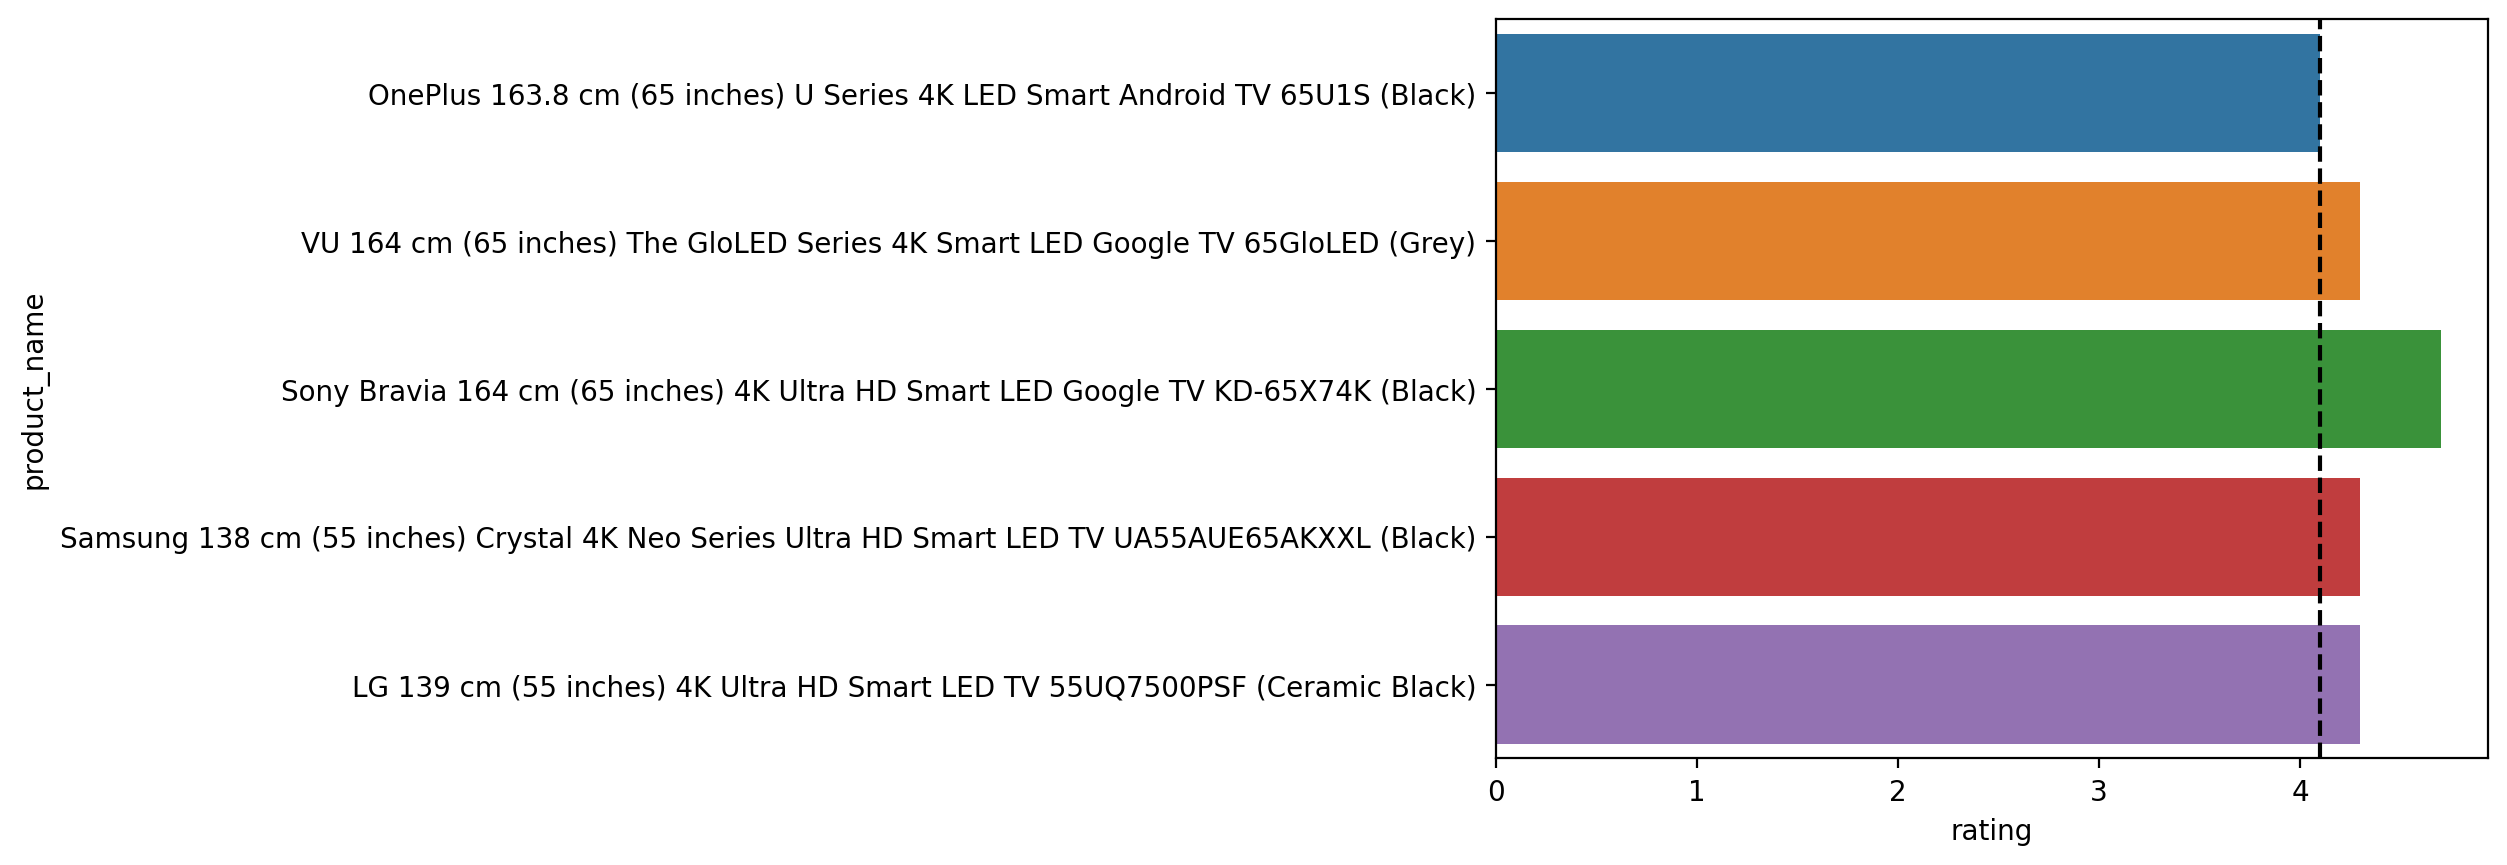

In [12]:
plt.figure(dpi=200)
sns.barplot(data = df_new, x = 'rating', y = 'product_name')
plt.axvline(x=new_product_df['rating'][0], color='black', linestyle='--', label=new_product_df['product_name'][0])
#plt.legend()
plt.show();

In [13]:
new_product_df['product_name']

0    Samsung 138 cm (55 inches) 4K Ultra HD Smart Q...
Name: product_name, dtype: object

/Users/arnav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/arnav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/arnav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


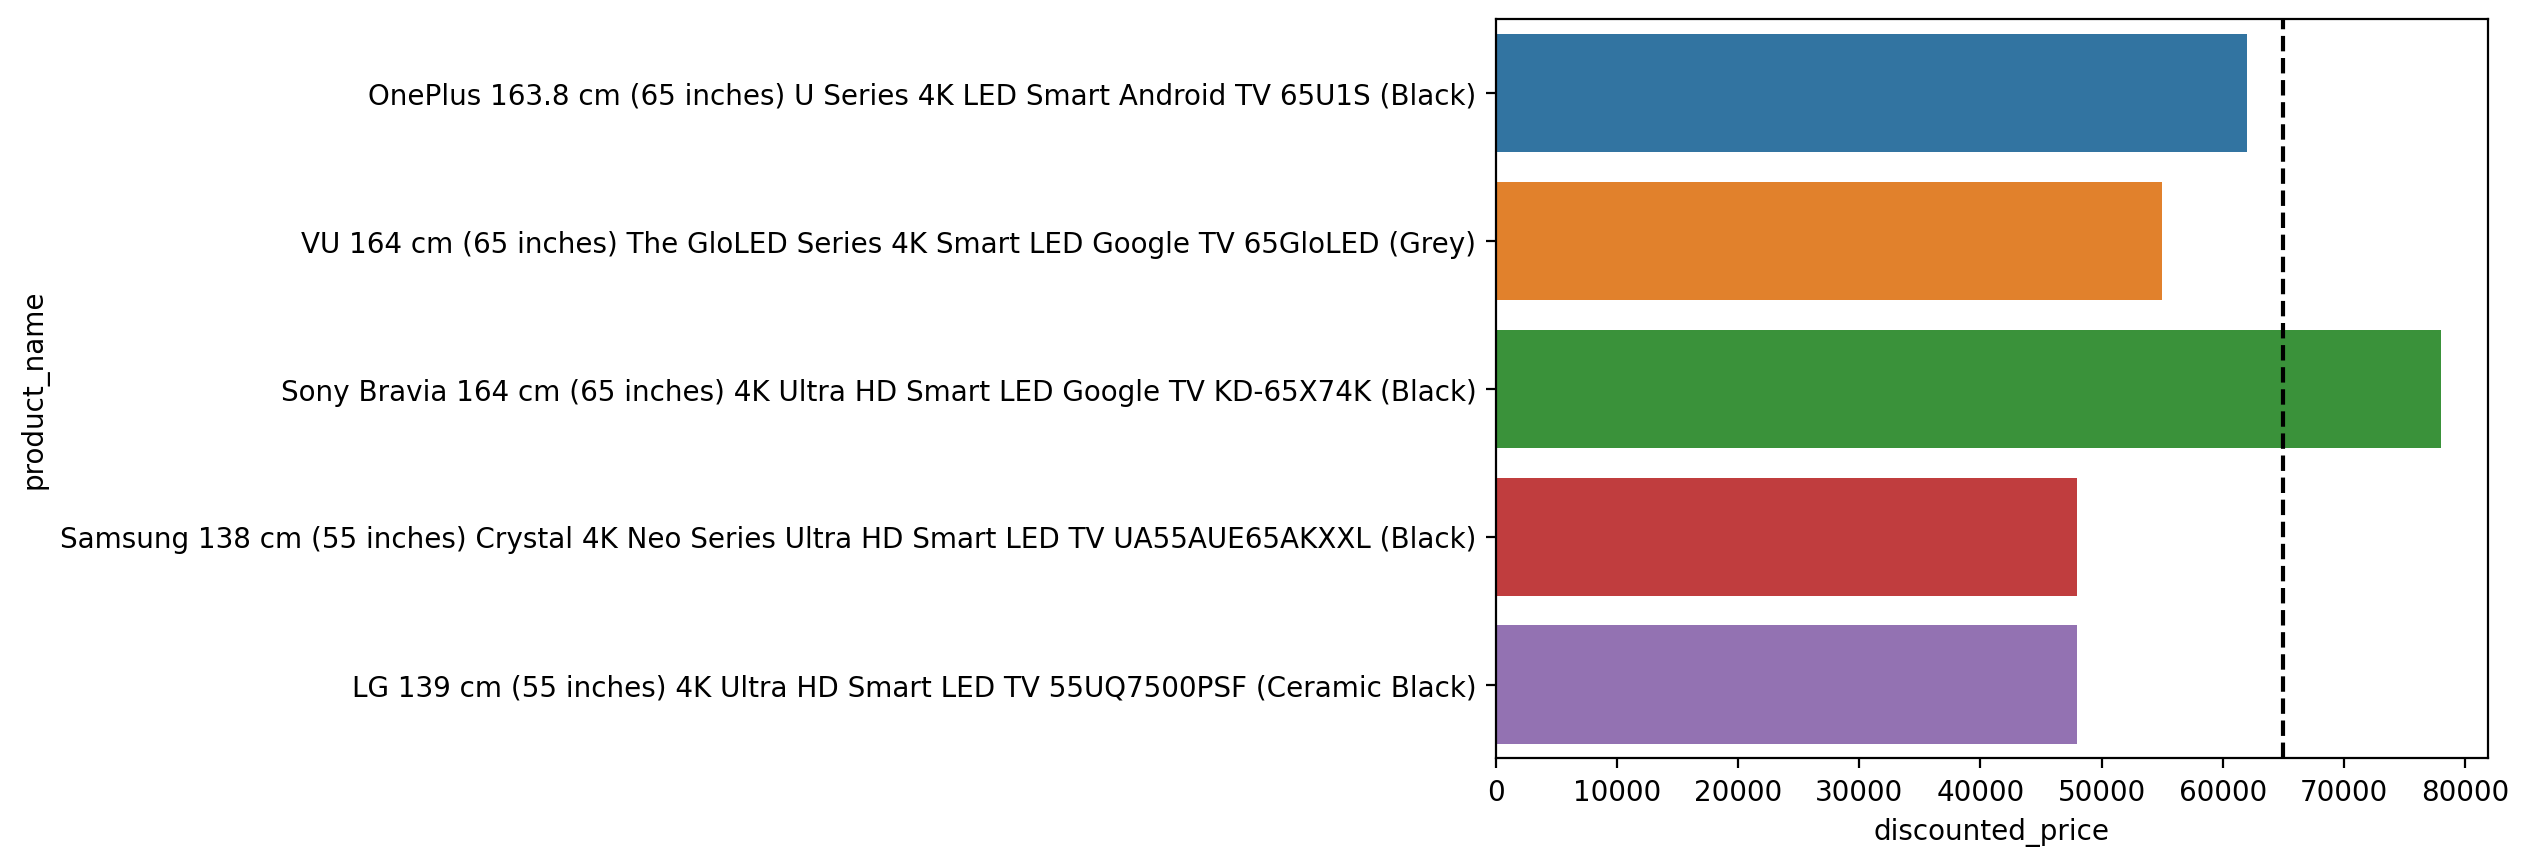

In [14]:
plt.figure(dpi=200)
sns.barplot(data = df_new, x = 'discounted_price', y = 'product_name')
plt.axvline(x=new_product_df['discounted_price'][0], color='black', linestyle='--')

/Users/arnav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/arnav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/arnav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


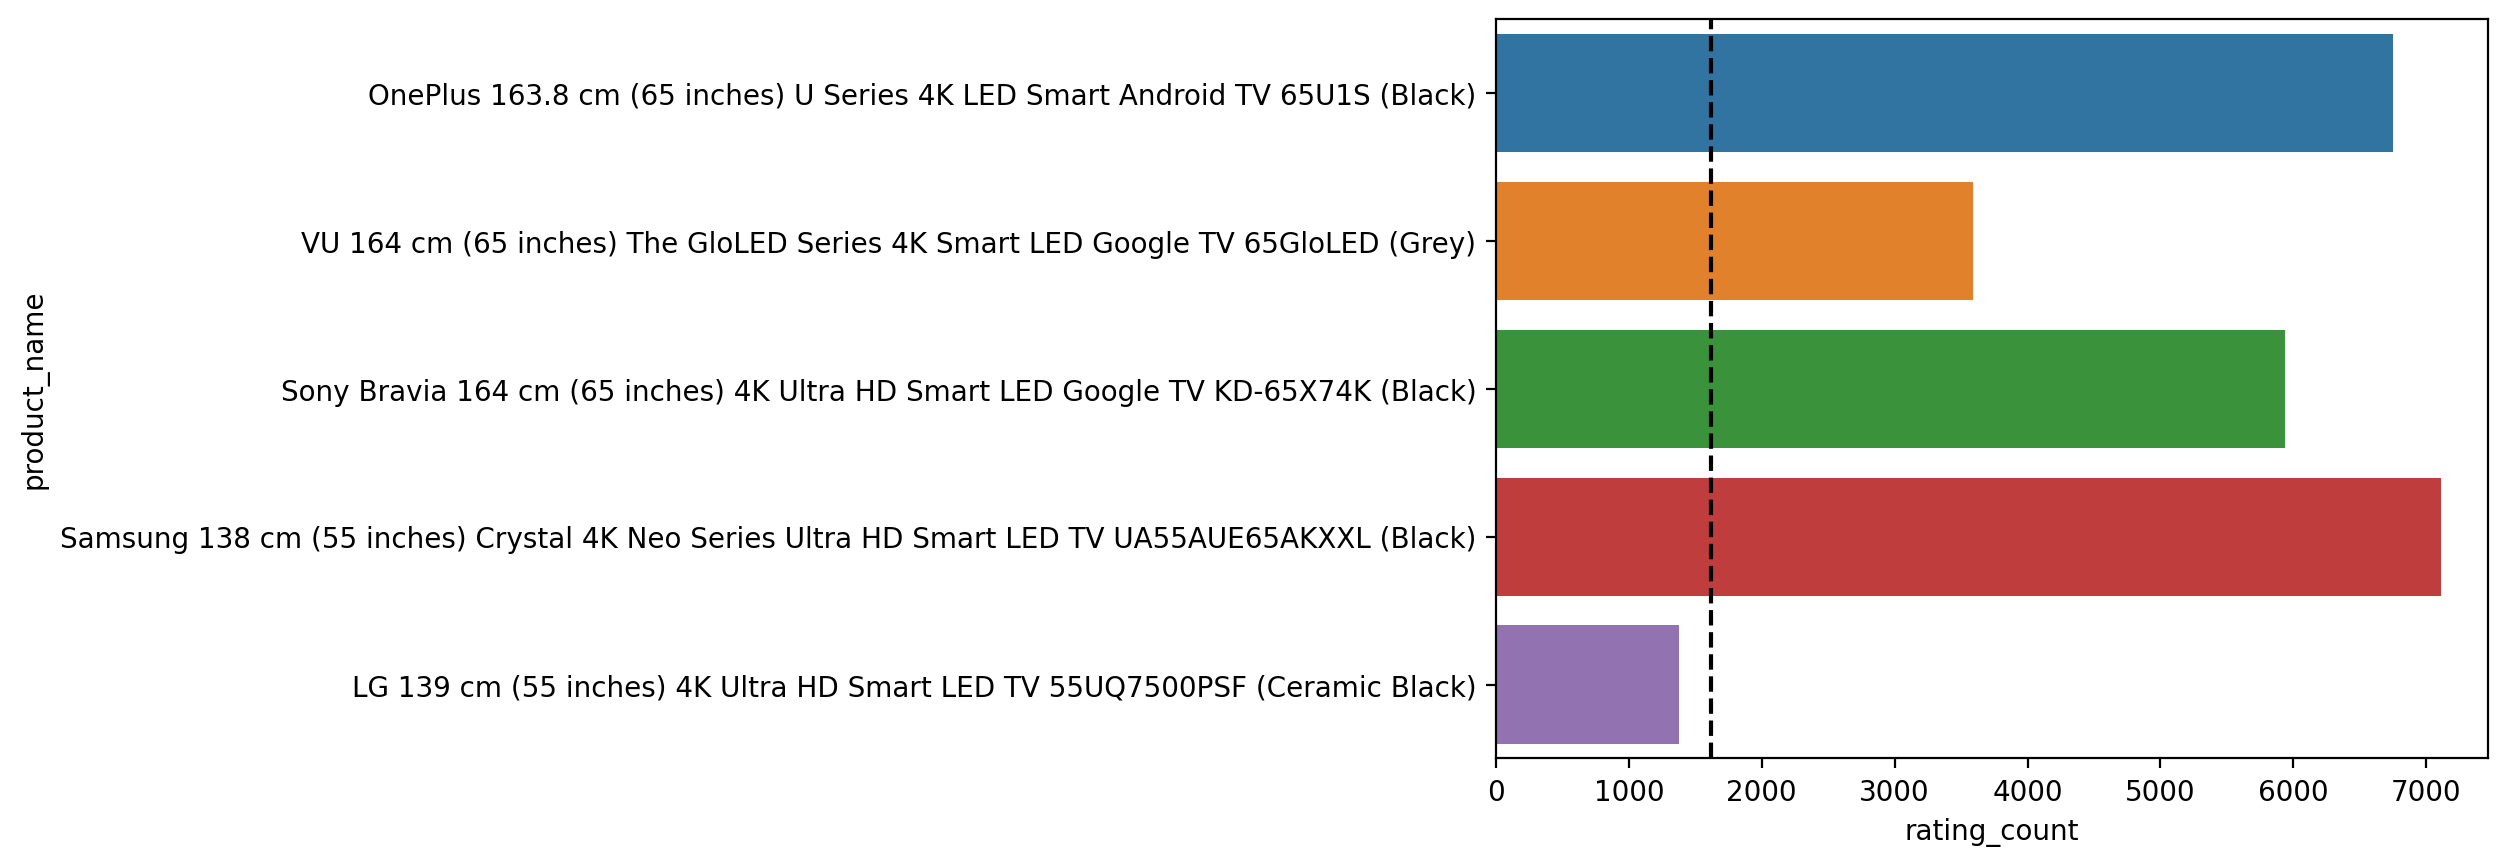

In [15]:
plt.figure(dpi=200)
sns.barplot(data = df_new, x = 'rating_count', y = 'product_name')
plt.axvline(x=new_product_df['rating_count'][0], color='black', linestyle='--')